### Protein Family Classification

In [1]:
import pandas as pd
import tensorflow as tf

import tarfile
import re
import urllib.request
import os
import random

import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from lazy import lazy

In [2]:
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
family_classification_metadata = pd.read_table('../hw5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../hw5/data/family_classification_sequences.tab')

In [4]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [5]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [6]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_YEFVC,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


In [7]:
family_cnt_exmp = dict()
for i in range(len(family_classification_metadata)):
    cur_fam_id = family_classification_metadata["FamilyID"][i]
    if (cur_fam_id not in family_cnt_exmp):
        family_cnt_exmp[cur_fam_id] = 0
    family_cnt_exmp[cur_fam_id] += 1

familys_sort = []
for k, v in family_cnt_exmp.items():
    familys_sort.append((v, k))
familys_sort.sort(reverse=True)

most_frequent_families = []
for i in range(1000):
    most_frequent_families.append(familys_sort[i][1])

print(most_frequent_families)

['MMR_HSR1', 'Helicase_C', 'ATP-synt_ab', '7tm_1', 'AA_kinase', 'AAA', 'tRNA-synt_1', 'tRNA-synt_2', 'MFS_1', 'HSP70', 'Oxidored_q1', 'His_biosynth', 'Cpn60_TCP1', 'EPSP_synthase', 'Aldedh', 'Shikimate_DH', 'GHMP_kinases_N', 'Ribosomal_S2', 'Ribosomal_S4', 'Ribosomal_L16', 'KOW', 'UPF0004', 'Ribosom_S12_S23', 'GHMP_kinases_C', 'Ribosomal_S14', 'Ribosomal_S11', 'UVR', 'Ribosomal_L33', 'BRCT', 'RF-1', 'Ank_2', 'Ribosomal_L20', 'RNA_pol_Rpb2_1', 'Ribosomal_S18', 'ATP-synt_B', 'Peptidase_M20', 'Ribosomal_L18e', 'GIDA', 'Oxidored_q2', 'Ldh_1_N', 'HD', 'Ribosomal_S10', 'PALP', 'Ribosomal_L18p', 'Ribosomal_L3', 'tRNA-synt_1g', 'UbiA', 'Ribosomal_L4', 'Ribosomal_S16', 'Ribosomal_S13', 'Methyltransf_5', 'Ribosomal_L32p', 'EF_TS', 'THF_DHG_CYH', 'OSCP', 'tRNA-synt_1e', 'SecA_SW', 'Ribosomal_L31', 'RNase_HII', 'Ribosomal_L27', 'IPPT', 'LepA_C', 'Ribosomal_L17', 'Ribosomal_L23', 'Ribosomal_L10', 'Ribosomal_L19', 'Ribosomal_S20p', 'Ribosomal_L35p', 'PGM_PMM_IV', 'AMP-binding', 'Ribosomal_L21p', 'tR

In [8]:
families_protein_id_list = dict()
for i in range(1000):
    families_protein_id_list[most_frequent_families[i]] = []

for i in range(len(family_classification_metadata)):
    cur_fam_id = family_classification_metadata["FamilyID"][i]
    if (cur_fam_id in families_protein_id_list):
        families_protein_id_list[cur_fam_id].append(i)

train_id = []
test_id = []
        
for i in range(1000):
    random.shuffle(families_protein_id_list[most_frequent_families[i]])
    cnt_train = len(families_protein_id_list[most_frequent_families[i]]) * 8//10
    for j in range(cnt_train):
        train_id.append(families_protein_id_list[most_frequent_families[i]][j])
    for j in range(cnt_train, len(families_protein_id_list[most_frequent_families[i]])):
        test_id.append(families_protein_id_list[most_frequent_families[i]][j])
random.shuffle(train_id)
random.shuffle(test_id)

print("train", train_id)
print("test", test_id)

train [259062, 23424, 256973, 75091, 273419, 143859, 272628, 311692, 130546, 176863, 99594, 231139, 259548, 184487, 241576, 310234, 90878, 271763, 61057, 129583, 96013, 306213, 183554, 43926, 43021, 82173, 141253, 140712, 161513, 248924, 201657, 254412, 20036, 74970, 279321, 131043, 308042, 117216, 246497, 17327, 199735, 152278, 58791, 127643, 311155, 61526, 87828, 7205, 243070, 276129, 278513, 136646, 47289, 71095, 154739, 151238, 213925, 89947, 98823, 136099, 99537, 185609, 236676, 202016, 132454, 134258, 279291, 176112, 284788, 109136, 178618, 115244, 34396, 44945, 66088, 321596, 20892, 130665, 207301, 52424, 234330, 184291, 275575, 90234, 143548, 147013, 187682, 71012, 255967, 207689, 4789, 36912, 143852, 297598, 113085, 87090, 227780, 1369, 231771, 131639, 63587, 202794, 230203, 14346, 94427, 139084, 189298, 213003, 138051, 54764, 63182, 116281, 214113, 82059, 348, 66694, 66202, 117742, 254208, 269756, 57706, 279455, 21236, 67349, 79921, 128597, 207342, 93426, 183406, 197966, 3189

In [9]:
embed_matrix = pd.read_csv("protVec_100d_3grams.csv", sep='\\t', header=None, engine='python', index_col=0)
embed_matrix.head()
print(embed_matrix)

            1         2         3         4         5         6         7    \
0                                                                             
AAA   -0.174060 -0.095756  0.059515  0.039673 -0.375934 -0.115415  0.090725   
ALA   -0.114085 -0.093288  0.155800 -0.037351 -0.121446  0.084037  0.023819   
LLL   -0.075594 -0.100834 -0.046616 -0.208980 -0.008596 -0.038612 -0.049360   
LAA   -0.137546 -0.135425  0.121566 -0.038295 -0.212129  0.040009  0.078545   
AAL   -0.156112 -0.133524  0.114426 -0.020264 -0.058513  0.057005  0.076881   
ALL   -0.056191 -0.144594  0.043214 -0.146754 -0.058094  0.024076  0.074966   
LLA   -0.177890 -0.001898  0.032638 -0.053407 -0.036736 -0.021239 -0.013052   
LAL   -0.188611 -0.002185  0.108836 -0.126098 -0.001931 -0.017215 -0.056647   
SSS    0.012405 -0.368833 -0.368951 -0.212781 -0.227907 -0.243726  0.056344   
EAL   -0.143734 -0.074760 -0.033182  0.061196 -0.107497  0.112890  0.055947   
AAG   -0.122047 -0.131051  0.082267  0.007056 -0.133

In [10]:
seq_to_id = dict()
id_list = embed_matrix.index.tolist();
for i in range(len(embed_matrix)):
    seq_to_id[id_list[i]] = i

print(seq_to_id)

{'AAA': 0, 'ALA': 1, 'LLL': 2, 'LAA': 3, 'AAL': 4, 'ALL': 5, 'LLA': 6, 'LAL': 7, 'SSS': 8, 'EAL': 9, 'AAG': 10, 'LGL': 11, 'LLS': 12, 'ELL': 13, 'LLE': 14, 'LLG': 15, 'SLL': 16, 'VAA': 17, 'LAE': 18, 'GGG': 19, 'AGL': 20, 'EEL': 21, 'AVA': 22, 'EEE': 23, 'LSL': 24, 'VLA': 25, 'ALG': 26, 'AAV': 27, 'LAG': 28, 'VLL': 29, 'GLL': 30, 'EAA': 31, 'AGA': 32, 'LLD': 33, 'ELA': 34, 'LEE': 35, 'ALE': 36, 'AVL': 37, 'LLK': 38, 'AEA': 39, 'AEL': 40, 'GLA': 41, 'LEA': 42, 'EKL': 43, 'RLL': 44, 'ALV': 45, 'ALR': 46, 'LGA': 47, 'LEK': 48, 'LKE': 49, 'AAE': 50, 'LVA': 51, 'DLL': 52, 'LLV': 53, 'LLR': 54, 'LVL': 55, 'LAR': 56, 'SSL': 57, 'LAS': 58, 'KLL': 59, 'GAA': 60, 'SAL': 61, 'TLL': 62, 'RAL': 63, 'LSA': 64, 'LAK': 65, 'DAL': 66, 'VAL': 67, 'GAG': 68, 'ALS': 69, 'AAR': 70, 'LSS': 71, 'LSG': 72, 'KAL': 73, 'SLA': 74, 'LAV': 75, 'LAD': 76, 'LGG': 77, 'ASL': 78, 'AIA': 79, 'RLA': 80, 'AGV': 81, 'SLS': 82, 'KEL': 83, 'LLT': 84, 'GAL': 85, 'VVA': 86, 'ERL': 87, 'LDL': 88, 'LEL': 89, 'ELE': 90, 'AAS': 9

In [11]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(embed_matrix)


tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
tsne_df.head()

,x0,x1
0,3.448284,-3.949775
1,2.758263,-4.583681
2,1.407525,-5.544826
3,2.729012,-4.329892
4,2.790550,-4.428670


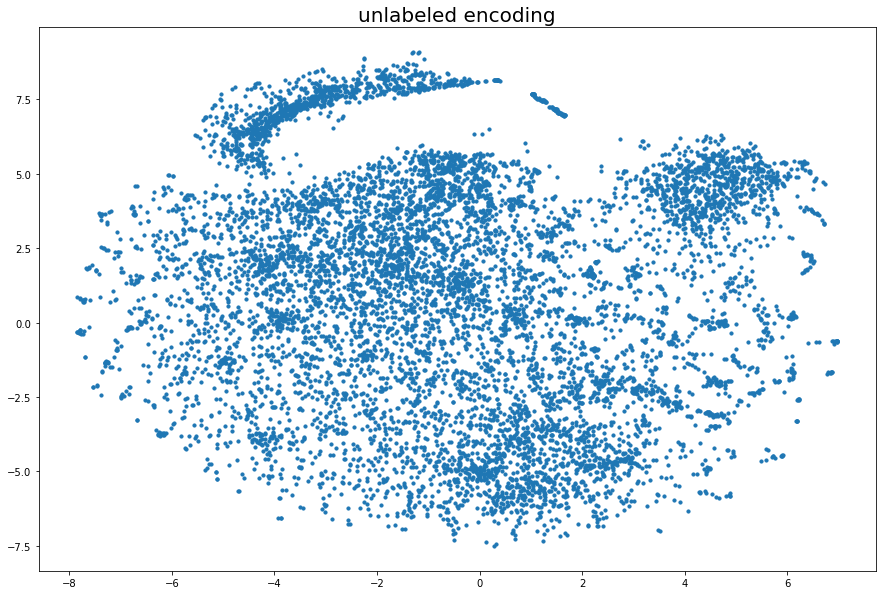

In [12]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

plot_tsne_df(tsne_df)

In [13]:
def acid_dict(seq, family):
    x0 = 0
    x1 = 0
    for i in range(0,len(seq),3):
        subseq = seq[i:i + 3]
        if (len(subseq) == 3):
            x0 += tsne_df["x0"][seq_to_id[subseq]]
            x1 += tsne_df["x1"][seq_to_id[subseq]]
    
    dres = dict()
    dres["x0"] = x0
    dres["x1"] = x1
    dres["fam"] = family
    return dres

p0 = most_frequent_families[0]
p1 = most_frequent_families[1] 
all_prot_dict = []
for i in range(len(family_classification_metadata)):
    if (family_classification_metadata["FamilyID"][i] == p0):
        all_prot_dict.append(acid_dict(family_classification_sequences["Sequences"][i], 0))
    
    if (family_classification_metadata["FamilyID"][i] == p1):
        all_prot_dict.append(acid_dict(family_classification_sequences["Sequences"][i], 1))


all_prot_df = pd.DataFrame(all_prot_dict)
all_prot_df.head()

,fam,x0,x1
0,1,-231.135196,128.645268
1,0,-72.976207,149.635431
2,1,-102.572238,242.292548
3,1,-72.493335,85.800772
4,1,-19.806498,151.765979


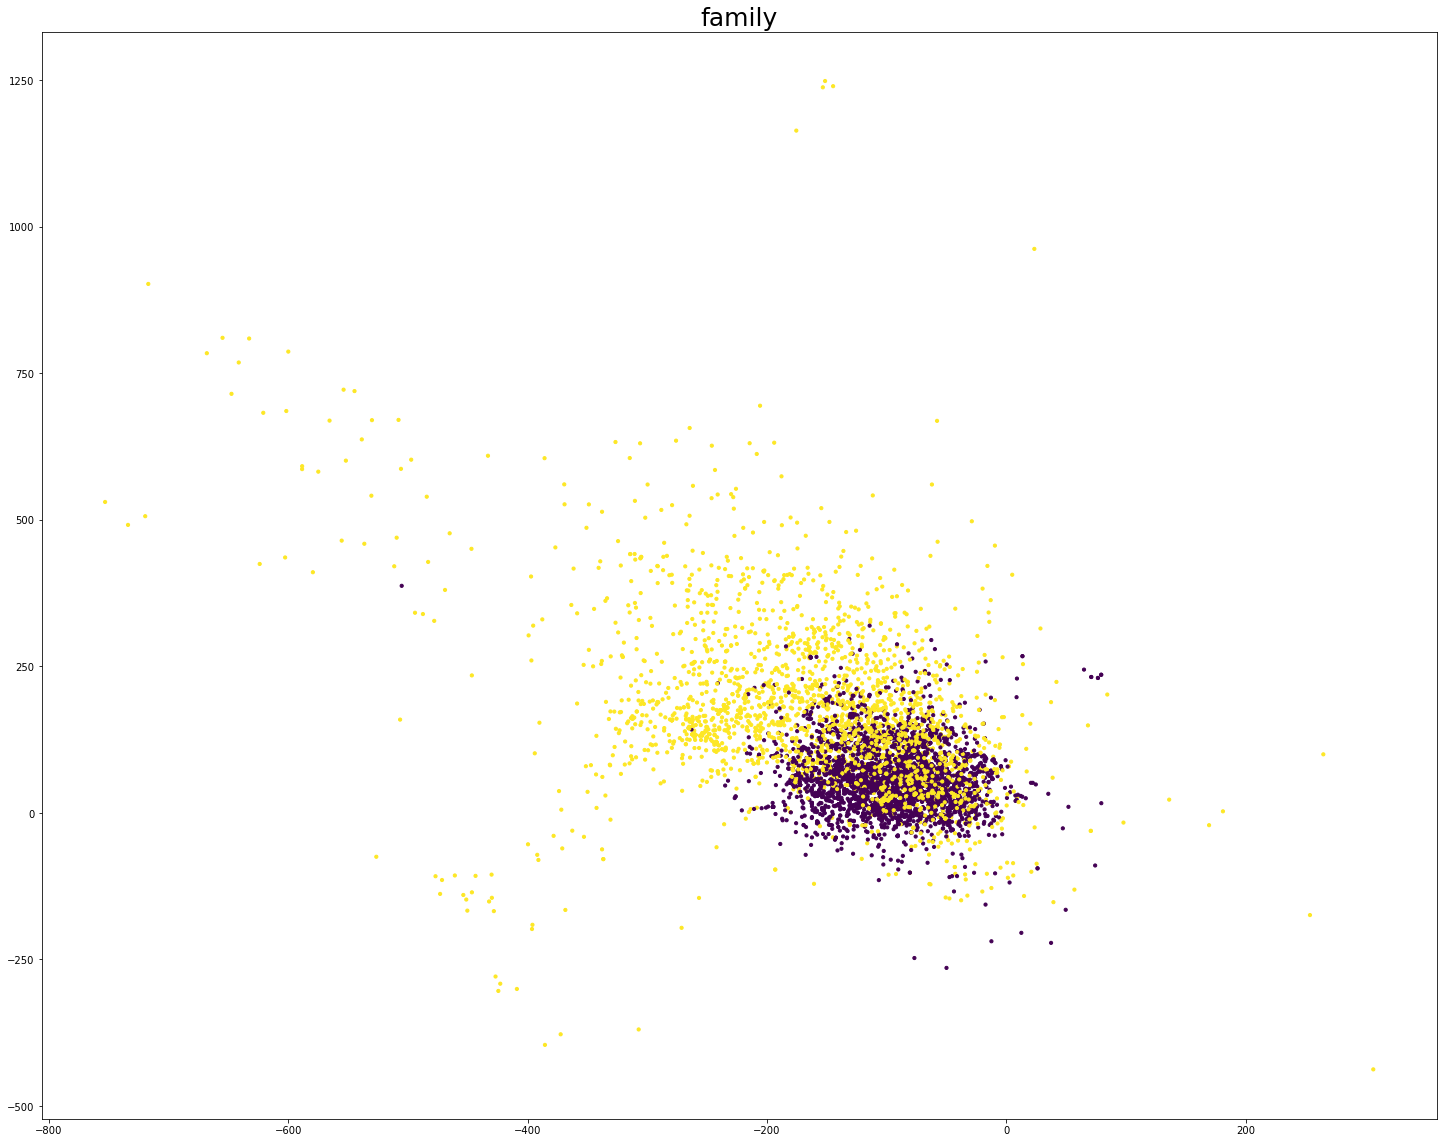

In [14]:
def plot_embedding_properties(all_prot_df):
    plt.figure(figsize=(25, 20))
    plt.title("family", fontsize=25)
    plt.scatter(all_prot_df.x0, all_prot_df.x1, c=all_prot_df.fam, s=10)
    plt.show()

plot_embedding_properties(all_prot_df)

In [15]:
class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, 1000])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

## Checkpoints

In [16]:
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'protRNN')

In [17]:
length = 0
for i in range(len(family_classification_sequences["Sequences"])):
    length = max(length, len(family_classification_sequences["Sequences"][i])//3 + 1)
print(length)

embed_len = 100

7385


In [18]:
def find_fam(sid):
    famName =  family_classification_metadata["FamilyID"][sid]
    for i in range(len(most_frequent_families)):
        if (most_frequent_families[i] == famName):
            return i
    return -1

def get_embed(sid):
    seq = family_classification_sequences["Sequences"][sid]
    data = np.zeros((length, embed_len))
    
    for i in range(0,len(seq),3):
        subseq = seq[i:i + 3]
        if subseq in seq_to_id:
            if (len(subseq) == 3):
                for j in range(1, 101):
                    data[i//3][j - 1] = embed_matrix[j][subseq]
    return data
    

In [19]:
def preprocess_batched(seq_id, batch_size):
    i = 0
    while (i < len(seq_id)):
        data = np.zeros((batch_size, length, embed_len))
        target = np.zeros((batch_size, 1000))
        
        for j in range(batch_size):
            if (i >= len(seq_id)):
                return
            sid = seq_id[i]
            i += 1
            label = find_fam(sid)
            data[j] = get_embed(sid)
            target[j][label] = 1
        yield data, target

In [20]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=100,
    optimizer=tf.train.RMSPropOptimizer(0.002),
    batch_size=20,
    gradient_clipping=100,
    seq_length=length,
    embed_length=embed_len
)

In [57]:
batches = preprocess_batched(train_id, params.batch_size)

In [58]:
import time
from datetime import timedelta

tf.reset_default_graph()
model = SequenceClassificationModel(params)
saver = tf.train.Saver()

with tf.Session() as sess:
    start_time = time.time()
    try:
        print("Trying to restore last checkpoint ...")

        # Use TensorFlow to find the latest checkpoint - if any.
        #last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

        # Try and load the data in the checkpoint.
        saver.restore(sess, save_path="checkpoints/protRNN-7190")

        # If we get to this point, the checkpoint was successfully loaded.
        print("Restored checkpoint from:", "checkpoints/protRNN-7190")
    except:
        # If the above failed for some reason, simply
        # initialize all the variables for the TensorFlow graph.
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())

    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    for index, batch in enumerate(batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        print('{}: {:3.1f}%'.format(index + 1, 100 * error))
        if index % 1 == 0:
            summary_writer.add_summary(summary_str, index)
        if index == 7200:
            break
        if index % 10 == 0:
            saver.save(sess,
                            save_path=save_path,
                            global_step=index)
            print("Saved checkpoint.") 
    
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/protRNN-7190
Restored checkpoint from: checkpoints/protRNN-7190
1: 60.0%
Saved checkpoint.


KeyboardInterrupt: 

In [35]:
def getEmbed(sid):
    X = np.zeros((len(sid), 100))
    ii = 0
    for cid in sid:
        if (ii % 100 == 0): 
            print(ii, len(sid))
        seq = family_classification_sequences["Sequences"][cid]
        for i in range(0,len(seq),3):
            subseq = seq[i:i + 3]
            if (len(subseq) == 3) and (subseq in seq_to_id):
                X[ii] += np.reshape(embed_matrix.loc[[subseq]].as_matrix(), 100)
        ii += 1
    return X

def getClasses(sid):
    Y = []
    for cid in sid:
        Y.append(find_fam(cid))
    return Y

In [36]:
trainX = getEmbed(train_id)
trainY = getClasses(train_id)

0 208531
100 208531
200 208531
300 208531
400 208531
500 208531
600 208531
700 208531
800 208531
900 208531
1000 208531
1100 208531
1200 208531
1300 208531
1400 208531
1500 208531
1600 208531
1700 208531
1800 208531
1900 208531
2000 208531
2100 208531
2200 208531
2300 208531
2400 208531
2500 208531
2600 208531
2700 208531
2800 208531
2900 208531
3000 208531
3100 208531
3200 208531
3300 208531
3400 208531
3500 208531
3600 208531
3700 208531
3800 208531
3900 208531
4000 208531
4100 208531
4200 208531
4300 208531
4400 208531
4500 208531
4600 208531
4700 208531
4800 208531
4900 208531
5000 208531
5100 208531
5200 208531
5300 208531
5400 208531
5500 208531
5600 208531
5700 208531
5800 208531
5900 208531
6000 208531
6100 208531
6200 208531
6300 208531
6400 208531
6500 208531
6600 208531
6700 208531
6800 208531
6900 208531
7000 208531
7100 208531
7200 208531
7300 208531
7400 208531
7500 208531
7600 208531
7700 208531
7800 208531
7900 208531
8000 208531
8100 208531
8200 208531
8300 208531
8400

63900 208531
64000 208531
64100 208531
64200 208531
64300 208531
64400 208531
64500 208531
64600 208531
64700 208531
64800 208531
64900 208531
65000 208531
65100 208531
65200 208531
65300 208531
65400 208531
65500 208531
65600 208531
65700 208531
65800 208531
65900 208531
66000 208531
66100 208531
66200 208531
66300 208531
66400 208531
66500 208531
66600 208531
66700 208531
66800 208531
66900 208531
67000 208531
67100 208531
67200 208531
67300 208531
67400 208531
67500 208531
67600 208531
67700 208531
67800 208531
67900 208531
68000 208531
68100 208531
68200 208531
68300 208531
68400 208531
68500 208531
68600 208531
68700 208531
68800 208531
68900 208531
69000 208531
69100 208531
69200 208531
69300 208531
69400 208531
69500 208531
69600 208531
69700 208531
69800 208531
69900 208531
70000 208531
70100 208531
70200 208531
70300 208531
70400 208531
70500 208531
70600 208531
70700 208531
70800 208531
70900 208531
71000 208531
71100 208531
71200 208531
71300 208531
71400 208531
71500 208531

125000 208531
125100 208531
125200 208531
125300 208531
125400 208531
125500 208531
125600 208531
125700 208531
125800 208531
125900 208531
126000 208531
126100 208531
126200 208531
126300 208531
126400 208531
126500 208531
126600 208531
126700 208531
126800 208531
126900 208531
127000 208531
127100 208531
127200 208531
127300 208531
127400 208531
127500 208531
127600 208531
127700 208531
127800 208531
127900 208531
128000 208531
128100 208531
128200 208531
128300 208531
128400 208531
128500 208531
128600 208531
128700 208531
128800 208531
128900 208531
129000 208531
129100 208531
129200 208531
129300 208531
129400 208531
129500 208531
129600 208531
129700 208531
129800 208531
129900 208531
130000 208531
130100 208531
130200 208531
130300 208531
130400 208531
130500 208531
130600 208531
130700 208531
130800 208531
130900 208531
131000 208531
131100 208531
131200 208531
131300 208531
131400 208531
131500 208531
131600 208531
131700 208531
131800 208531
131900 208531
132000 208531
132100

183600 208531
183700 208531
183800 208531
183900 208531
184000 208531
184100 208531
184200 208531
184300 208531
184400 208531
184500 208531
184600 208531
184700 208531
184800 208531
184900 208531
185000 208531
185100 208531
185200 208531
185300 208531
185400 208531
185500 208531
185600 208531
185700 208531
185800 208531
185900 208531
186000 208531
186100 208531
186200 208531
186300 208531
186400 208531
186500 208531
186600 208531
186700 208531
186800 208531
186900 208531
187000 208531
187100 208531
187200 208531
187300 208531
187400 208531
187500 208531
187600 208531
187700 208531
187800 208531
187900 208531
188000 208531
188100 208531
188200 208531
188300 208531
188400 208531
188500 208531
188600 208531
188700 208531
188800 208531
188900 208531
189000 208531
189100 208531
189200 208531
189300 208531
189400 208531
189500 208531
189600 208531
189700 208531
189800 208531
189900 208531
190000 208531
190100 208531
190200 208531
190300 208531
190400 208531
190500 208531
190600 208531
190700

In [43]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [44]:
testX = getEmbed(test_id)
ypred = clf.predict(testX)
print(ypred)

0 52618
100 52618
200 52618
300 52618
400 52618
500 52618
600 52618
700 52618
800 52618
900 52618
1000 52618
1100 52618
1200 52618
1300 52618
1400 52618
1500 52618
1600 52618
1700 52618
1800 52618
1900 52618
2000 52618
2100 52618
2200 52618
2300 52618
2400 52618
2500 52618
2600 52618
2700 52618
2800 52618
2900 52618
3000 52618
3100 52618
3200 52618
3300 52618
3400 52618
3500 52618
3600 52618
3700 52618
3800 52618
3900 52618
4000 52618
4100 52618
4200 52618
4300 52618
4400 52618
4500 52618
4600 52618
4700 52618
4800 52618
4900 52618
5000 52618
5100 52618
5200 52618
5300 52618
5400 52618
5500 52618
5600 52618
5700 52618
5800 52618
5900 52618
6000 52618
6100 52618
6200 52618
6300 52618
6400 52618
6500 52618
6600 52618
6700 52618
6800 52618
6900 52618
7000 52618
7100 52618
7200 52618
7300 52618
7400 52618
7500 52618
7600 52618
7700 52618
7800 52618
7900 52618
8000 52618
8100 52618
8200 52618
8300 52618
8400 52618
8500 52618
8600 52618
8700 52618
8800 52618
8900 52618
9000 52618
9100 52618


In [45]:
testY = getClasses(test_id)
print(testY)

[722, 556, 1, 86, 84, 25, 94, 22, 497, 710, 153, 44, 134, 200, 185, 49, 287, 498, 95, 402, 95, 2, 205, 674, 72, 51, 914, 11, 12, 602, 30, 336, 87, 127, 14, 137, 35, 767, 447, 17, 69, 257, 813, 736, 232, 152, 169, 546, 6, 210, 3, 379, 202, 102, 359, 261, 738, 518, 295, 503, 165, 145, 3, 452, 883, 25, 206, 476, 88, 217, 449, 874, 73, 311, 48, 512, 158, 305, 353, 416, 167, 154, 183, 463, 48, 99, 210, 71, 154, 81, 10, 999, 18, 461, 28, 43, 323, 10, 51, 177, 98, 52, 72, 147, 0, 435, 129, 176, 211, 329, 229, 85, 202, 137, 995, 284, 289, 6, 30, 204, 12, 769, 121, 438, 471, 143, 146, 31, 44, 123, 111, 215, 23, 517, 62, 693, 12, 387, 115, 63, 172, 733, 104, 193, 230, 91, 197, 136, 736, 459, 4, 1, 186, 401, 222, 23, 39, 233, 371, 63, 16, 58, 330, 25, 21, 734, 6, 33, 410, 75, 169, 57, 104, 632, 560, 125, 31, 123, 92, 142, 58, 501, 339, 415, 46, 192, 349, 168, 979, 276, 85, 425, 393, 58, 96, 125, 72, 662, 112, 152, 4, 403, 1, 601, 639, 84, 55, 38, 552, 89, 136, 373, 657, 442, 320, 0, 68, 355, 684,

In [55]:
def preprocess_test(seq_id):
    data = np.zeros((20, length, embed_len))
        
    for j in range(20):
        sid = seq_id[j]
        data[j] = get_embed(sid)
    return data

In [65]:
yrnnpred = []
with tf.Session() as sess:
    try:
        print("Trying to restore last checkpoint ...")

        # Use TensorFlow to find the latest checkpoint - if any.
        #last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

        # Try and load the data in the checkpoint.
        saver.restore(sess, save_path="checkpoints/protRNN-7190")

        # If we get to this point, the checkpoint was successfully loaded.
        print("Restored checkpoint from:", "checkpoints/protRNN-7190")
    except:
        # If the above failed for some reason, simply
        # initialize all the variables for the TensorFlow graph.
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())
        
    for j in range(0, len(test_id), 20):
        print(j, len(test_id))
        data = np.zeros((min(20, len(test_id) - j), length, embed_len))
        for g in range(min(20, len(test_id) - j)):
            data[g] = get_embed(test_id[g + j])
        feed = {model.data: data}
        yprd = sess.run(model.prediction, feed)
        for g in range(min(20, len(test_id) - j)):
            yrnnpred.append(np.argmax(yprd[g]))

print(yrnnpred)

Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from checkpoints/protRNN-7190
Restored checkpoint from: checkpoints/protRNN-7190
0 52618
20 52618
40 52618
60 52618
80 52618
100 52618
120 52618
140 52618
160 52618
180 52618
200 52618
220 52618
240 52618
260 52618
280 52618
300 52618
320 52618
340 52618
360 52618
380 52618
400 52618
420 52618
440 52618
460 52618
480 52618
500 52618
520 52618
540 52618
560 52618
580 52618
600 52618
620 52618
640 52618
660 52618
680 52618
700 52618
720 52618
740 52618
760 52618
780 52618
800 52618
820 52618
840 52618
860 52618
880 52618
900 52618
920 52618
940 52618
960 52618
980 52618
1000 52618
1020 52618
1040 52618
1060 52618
1080 52618
1100 52618
1120 52618
1140 52618
1160 52618
1180 52618
1200 52618
1220 52618
1240 52618
1260 52618
1280 52618
1300 52618
1320 52618
1340 52618
1360 52618
1380 52618
1400 52618
1420 52618
1440 52618
1460 52618
1480 52618
1500 52618
1520 52618
1540 52618
1560 52618
1580 52618
1600 52618
1620 5261

14340 52618
14360 52618
14380 52618
14400 52618
14420 52618
14440 52618
14460 52618
14480 52618
14500 52618
14520 52618
14540 52618
14560 52618
14580 52618
14600 52618
14620 52618
14640 52618
14660 52618
14680 52618
14700 52618
14720 52618
14740 52618
14760 52618
14780 52618
14800 52618
14820 52618
14840 52618
14860 52618
14880 52618
14900 52618
14920 52618
14940 52618
14960 52618
14980 52618
15000 52618
15020 52618
15040 52618
15060 52618
15080 52618
15100 52618
15120 52618
15140 52618
15160 52618
15180 52618
15200 52618
15220 52618
15240 52618
15260 52618
15280 52618
15300 52618
15320 52618
15340 52618
15360 52618
15380 52618
15400 52618
15420 52618
15440 52618
15460 52618
15480 52618
15500 52618
15520 52618
15540 52618
15560 52618
15580 52618
15600 52618
15620 52618
15640 52618
15660 52618
15680 52618
15700 52618
15720 52618
15740 52618
15760 52618
15780 52618
15800 52618
15820 52618
15840 52618
15860 52618
15880 52618
15900 52618
15920 52618
15940 52618
15960 52618
15980 52618
1600

28000 52618
28020 52618
28040 52618
28060 52618
28080 52618
28100 52618
28120 52618
28140 52618
28160 52618
28180 52618
28200 52618
28220 52618
28240 52618
28260 52618
28280 52618
28300 52618
28320 52618
28340 52618
28360 52618
28380 52618
28400 52618
28420 52618
28440 52618
28460 52618
28480 52618
28500 52618
28520 52618
28540 52618
28560 52618
28580 52618
28600 52618
28620 52618
28640 52618
28660 52618
28680 52618
28700 52618
28720 52618
28740 52618
28760 52618
28780 52618
28800 52618
28820 52618
28840 52618
28860 52618
28880 52618
28900 52618
28920 52618
28940 52618
28960 52618
28980 52618
29000 52618
29020 52618
29040 52618
29060 52618
29080 52618
29100 52618
29120 52618
29140 52618
29160 52618
29180 52618
29200 52618
29220 52618
29240 52618
29260 52618
29280 52618
29300 52618
29320 52618
29340 52618
29360 52618
29380 52618
29400 52618
29420 52618
29440 52618
29460 52618
29480 52618
29500 52618
29520 52618
29540 52618
29560 52618
29580 52618
29600 52618
29620 52618
29640 52618
2966

41660 52618
41680 52618
41700 52618
41720 52618
41740 52618
41760 52618
41780 52618
41800 52618
41820 52618
41840 52618
41860 52618
41880 52618
41900 52618
41920 52618
41940 52618
41960 52618
41980 52618
42000 52618
42020 52618
42040 52618
42060 52618
42080 52618
42100 52618
42120 52618
42140 52618
42160 52618
42180 52618
42200 52618
42220 52618
42240 52618
42260 52618
42280 52618
42300 52618
42320 52618
42340 52618
42360 52618
42380 52618
42400 52618
42420 52618
42440 52618
42460 52618
42480 52618
42500 52618
42520 52618
42540 52618
42560 52618
42580 52618
42600 52618
42620 52618
42640 52618
42660 52618
42680 52618
42700 52618
42720 52618
42740 52618
42760 52618
42780 52618
42800 52618
42820 52618
42840 52618
42860 52618
42880 52618
42900 52618
42920 52618
42940 52618
42960 52618
42980 52618
43000 52618
43020 52618
43040 52618
43060 52618
43080 52618
43100 52618
43120 52618
43140 52618
43160 52618
43180 52618
43200 52618
43220 52618
43240 52618
43260 52618
43280 52618
43300 52618
4332

In [66]:
from sklearn.metrics import accuracy_score

accuracyRF = accuracy_score(testY, ypred)
print("Random Forest accuracy: %.2f%%" % (accuracyRF * 100.0))


accuracyRNN = accuracy_score(testY, yrnnpred)
print("RNN accuracy: %.2f%%" % (accuracyRNN * 100.0))

Random Forest accuracy: 57.06%
RNN accuracy: 30.24%


In [40]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


#dtrain = xgb.DMatrix(trainX, label=trainY)

In [42]:
model = XGBClassifier(silent=True)
model.fit(trainX, trainY)
#param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
#bst = xgb.train(param, dtrain, 10)

KeyboardInterrupt: 

In [ ]:
ypred = bst.predict(getEmbed(test_id))
print(ypred)
testY = getClasses(test_id)
print(testY)

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

scaling = StandardScaler()
scaling.fit(trainX)
trainX = scaling.transform(trainX)

In [ ]:
clf = svm.SVC()
clf.fit(trainX, trainY)

In [ ]:
testX = getEmbed(test_id)
testX = scaling.transform(testX)

testY = getClasses(test_id)

predictY = clf.predict(testX)
print(predictY)
print(testY)

#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you